Merged dataset shape: (782, 11)
       country  year  happiness_rank  happiness_score      gdp   family  \
0  Switzerland  2015               1            7.587  1.39651  1.34951   
1      Iceland  2015               2            7.561  1.30232  1.40223   
2      Denmark  2015               3            7.527  1.32548  1.36058   
3       Norway  2015               4            7.522  1.45900  1.33095   
4       Canada  2015               5            7.427  1.32629  1.32261   

    health  freedom  generosity    trust  dystopia_residual  
0  0.94143  0.66557     0.29678  0.41978            2.51738  
1  0.94784  0.62877     0.43630  0.14145            2.70201  
2  0.87464  0.64938     0.34139  0.48357            2.49204  
3  0.88521  0.66973     0.34699  0.36503            2.46531  
4  0.90563  0.63297     0.45811  0.32957            2.45176  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 11 columns):
 #   Column             Non-Null Count  

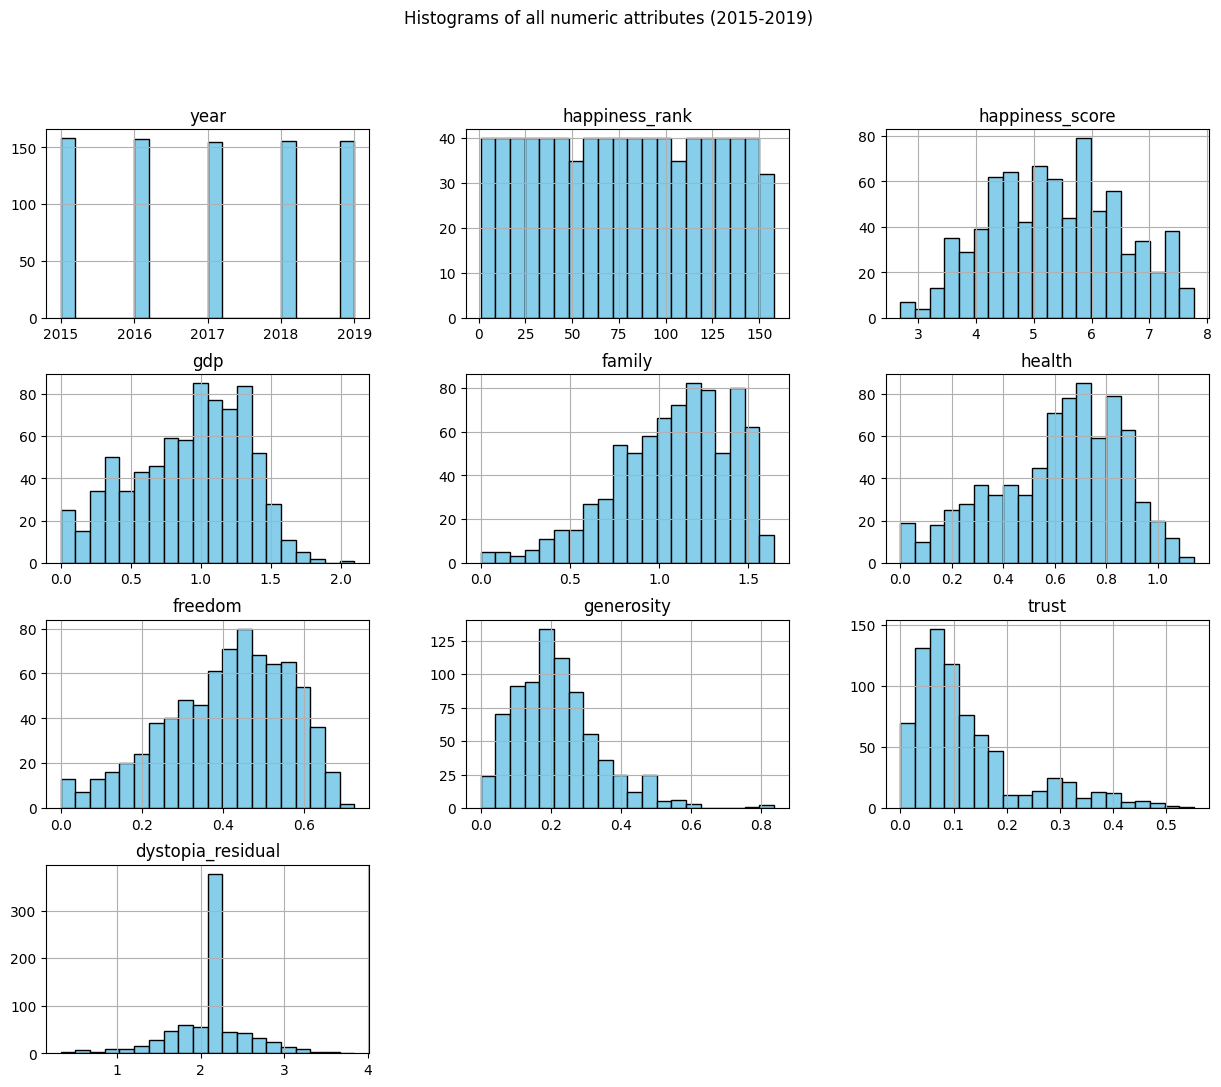

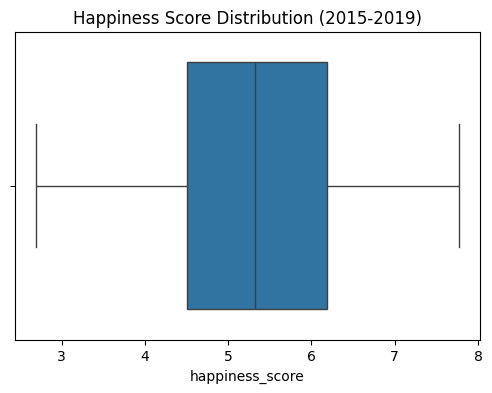

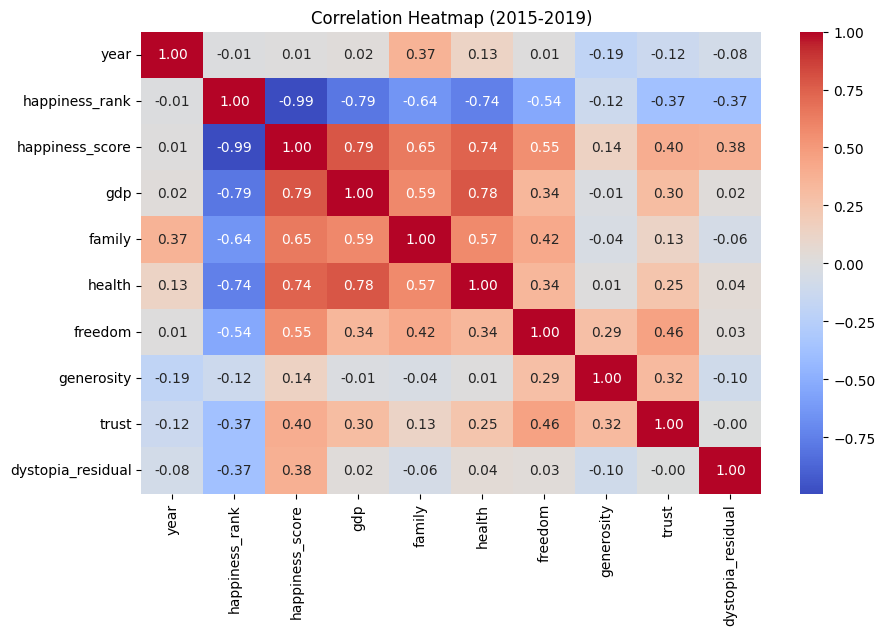

In [ ]:
# Step 1 (EDA):
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
files = { 2015: "2015.csv", 2016: "2016.csv", 2017: "2017.csv", 2018: "2018.csv", 2019: "2019.csv" }

def clean_happiness_df(df, year):
    # Normalize column names
    df.columns = df.columns.str.lower().str.replace('[ .]', '_', regex=True).str.strip()

    # Mapping to standard names
    col_map = {
    # Country / Region
    "country": "country",
    "country_or_region": "country",

    # Rank
    "happiness_rank": "happiness_rank",
    "happiness.rank": "happiness_rank",
    "happiness.rank": "happiness_rank",
    "overall_rank": "happiness_rank",

    # Score
    "happiness_score": "happiness_score",
    "score": "happiness_score",

    # GDP
    "economy_(gdp_per_capita)": "gdp",
    "economy..gdp.per_capita.": "gdp",
    "economy__gdp_per_capita_": "gdp",
    "gdp_per_capita": "gdp",
    "gdp per capita": "gdp",

    # Family / Social Support
    "family": "family",
    "social_support": "family",

    # Health
    "health_(life_expectancy)": "health",
    "health..life.expectancy.": "health",
    "health__life_expectancy_": "health",
    "healthy_life_expectancy": "health",

    # Freedom
    "freedom": "freedom",
    "freedom_to_make_life_choices": "freedom",

    # Generosity
    "generosity": "generosity",

    # Trust / Corruption
    "trust_(government_corruption)": "trust",
    "trust..government_corruption.": "trust",
    "trust__government_corruption_": "trust",
    "perceptions_of_corruption": "trust",

    # Dystopia Residual
    "dystopia_residual": "dystopia_residual",
    "dystopia.residual": "dystopia_residual"
}

    # Rename columns
    df = df.rename(columns={k:v for k,v in col_map.items() if k in df.columns})

    # Add year
    df['year'] = year

    # Keep only relevant columns
    cols_to_keep = ['country','year','happiness_rank','happiness_score','gdp','family','health','freedom','generosity','trust','dystopia_residual']
    return df[[c for c in cols_to_keep if c in df.columns]]

# Clean and merge all datasets
dfs = [clean_happiness_df(pd.read_csv(path), year) for year, path in files.items()]
happiness_all = pd.concat(dfs, ignore_index=True)

# Fill missing numeric values with median
num_cols = happiness_all.select_dtypes(include=[np.number]).columns
happiness_all[num_cols] = happiness_all[num_cols].fillna(happiness_all[num_cols].median())

print("Merged dataset shape:", happiness_all.shape)
print(happiness_all.head())
print(happiness_all.info())
print(happiness_all.isnull().sum())

# Histograms for all numeric columns
happiness_all.hist(figsize=(15, 12), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Histograms of all numeric attributes (2015-2019)")
plt.show()

# Boxplot for Happiness Score
plt.figure(figsize=(6, 4))
sns.boxplot(x=happiness_all["happiness_score"])
plt.title("Happiness Score Distribution (2015-2019)")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
corr = happiness_all.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (2015-2019)")
plt.show()


In [ ]:
#Combine to a single dataset
happiness_all.to_excel("Final_dataset.xlsx", index=False)

In [ ]:
# Step 2 (Frame the problem & Test Set):
from sklearn.model_selection import train_test_split

X = happiness_all.drop(columns=['happiness_score'])
y = happiness_all['happiness_score']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

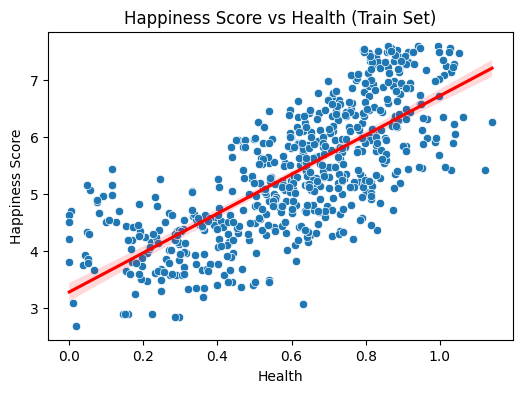

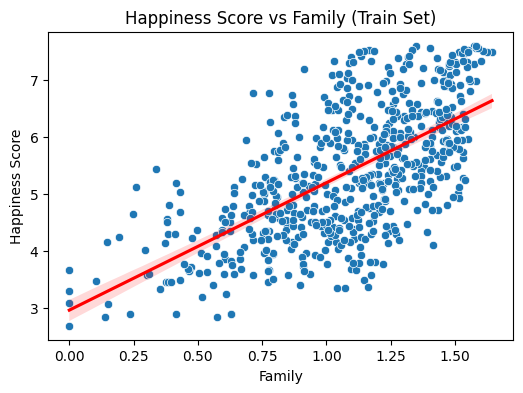

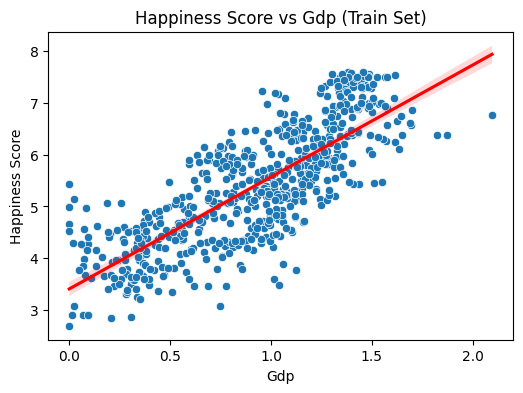

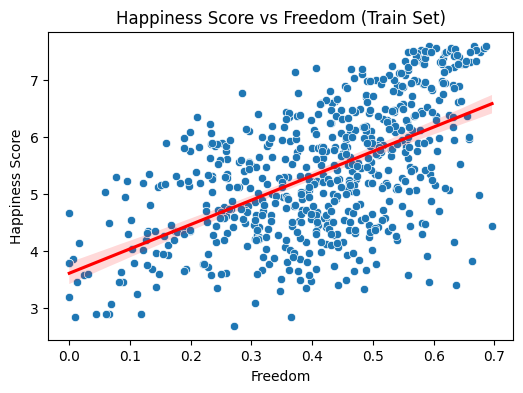

/tmp/ipython-input-3088826420.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=X_train['year'], y=y_train, ci=None)


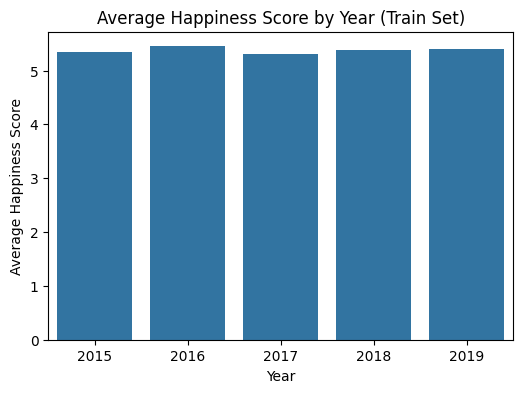

In [ ]:
# Step 3 (Visual Insights):
top_predictors = ['health', 'family', 'gdp', 'freedom']

for col in top_predictors:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=X_train[col], y=y_train)
    sns.regplot(x=X_train[col], y=y_train, scatter=False, color='red')
    plt.xlabel(col.capitalize())
    plt.ylabel("Happiness Score")
    plt.title(f'Happiness Score vs {col.capitalize()} (Train Set)')
    plt.show()

# Average Happiness Score by Year (training data)
plt.figure(figsize=(6,4))
sns.barplot(x=X_train['year'], y=y_train, ci=None)
plt.xlabel("Year")
plt.ylabel("Average Happiness Score")
plt.title("Average Happiness Score by Year (Train Set)")
plt.show()


In [ ]:
# Step 4 – Categorical Handling
categorical_cols = ['country']
numeric_cols = [
    'gdp','family','health','freedom',
    'generosity','trust','dystopia_residual'
]

# Step 5 – Custom Transformer (new feature)
from sklearn.base import BaseEstimator, TransformerMixin

class GdpFamilyRatio(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['gdp_family_ratio'] = X['gdp'] / (X['family'] + 1e-6)  # avoid division by zero
        return X

# Update numeric list to include new feature
numeric_cols = numeric_cols + ['gdp_family_ratio']

# Step 6 & 7 – Feature Scaling + Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Build full pipeline including custom transformer
pipeline = Pipeline([
    ('custom', GdpFamilyRatio()),  # Step 5: create gdp/family ratio
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_cols),       # Step 6: scale numeric
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore"), categorical_cols)  # Step 4: encode categorical
        ]
    ))
])

# Fit pipeline ONLY on train
pipeline.fit(X_train)

# Transform train and test
X_train_processed = pipeline.transform(X_train)
X_test_processed = pipeline.transform(X_test)

print("Processed train shape:", X_train_processed.shape)
print("Processed test shape:", X_test_processed.shape)


Processed train shape: (625, 177)
Processed test shape: (157, 177)


In [ ]:
# ---------------- Step 8-12: Models ----------------
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def evaluate(model, X, y, name="Model"):
    pred = model.predict(X)
    mae = mean_absolute_error(y, pred)
    rmse = np.sqrt(mean_squared_error(y, pred))
    r2 = r2_score(y, pred)
    print(f"{name:<25} MAE={mae:.4f} RMSE={rmse:.4f} R²={r2:.4f}")
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

results = []

# Step 8: Linear Regression (baseline)
split_sizes = [0.10, 0.25, 0.30]
lr_split_results = []

for split in split_sizes:
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
        X, y, test_size=split, random_state=42
    )
    X_train_proc = pipeline.fit_transform(X_train_s)
    X_test_proc = pipeline.transform(X_test_s)

    lr_temp = LinearRegression()
    lr_temp.fit(X_train_proc, y_train_s)

    pred = lr_temp.predict(X_test_proc)
    mae = mean_absolute_error(y_test_s, pred)
    rmse = np.sqrt(mean_squared_error(y_test_s, pred))
    r2 = r2_score(y_test_s, pred)

    print(f"[LinearRegression Split={int(split*100)}%] MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")
    lr_split_results.append({
        "Model": f"LinearRegression_{int(split*100)}%",
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })

# Append results to master table
results_df = pd.concat([results_df, pd.DataFrame(lr_split_results)], ignore_index=True)

# Step 9: Ridge Regression
ridge = Ridge(random_state=42)
param_grid = {"alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_ridge = GridSearchCV(ridge, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_ridge.fit(X_train_processed, y_train)
ridge_best = grid_ridge.best_estimator_
print("Ridge Best Alpha:", grid_ridge.best_params_)
results.append(evaluate(ridge_best, X_test_processed, y_test, "RidgeRegression"))

# Step 10: Polynomial Regression (degree=2)
poly_pipe = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr", LinearRegression())
])
poly_pipe.fit(X_train_processed, y_train)
results.append(evaluate(poly_pipe, X_test_processed, y_test, "PolyRegression_deg2"))

# Step 11: Decision Tree
param_tree = {"max_depth": [3, 5, None], "min_samples_leaf": [1, 3, 5]}
tree = DecisionTreeRegressor(random_state=42)
grid_tree = GridSearchCV(tree, param_grid=param_tree, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_tree.fit(X_train_processed, y_train)
tree_best = grid_tree.best_estimator_
print("DecisionTree Best Params:", grid_tree.best_params_)
results.append(evaluate(tree_best, X_test_processed, y_test, "DecisionTree"))

# Step 12: Random Forest
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
param_rf = {
    "n_estimators": np.arange(50, 201, 25),
    "max_depth": [None, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.5, 0.8]
}
rand_rf = RandomizedSearchCV(rf, param_distributions=param_rf, n_iter=10, cv=5, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1)
rand_rf.fit(X_train_processed, y_train)
rf_best = rand_rf.best_estimator_
print("RandomForest Best Params:", rand_rf.best_params_)
results.append(evaluate(rf_best, X_test_processed, y_test, "RandomForest"))

# Collect Results
all_results = lr_split_results + results
results_df = pd.DataFrame(all_results)
print("\nSummary of all models:")
print(results_df)


[LinearRegression Split=10%] MAE=0.1673, RMSE=0.2341, R²=0.9561
[LinearRegression Split=25%] MAE=0.1739, RMSE=0.2484, R²=0.9501
[LinearRegression Split=30%] MAE=0.1736, RMSE=0.2426, R²=0.9529


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Ridge Best Alpha: {'alpha': 0.1}
RidgeRegression           MAE=0.1773 RMSE=0.2550 R²=0.9465
PolyRegression_deg2       MAE=0.1991 RMSE=0.3121 R²=0.9199
DecisionTree Best Params: {'max_depth': None, 'min_samples_leaf': 1}
DecisionTree              MAE=0.3829 RMSE=0.5282 R²=0.7706
RandomForest Best Params: {'n_estimators': np.int64(150), 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 20}
RandomForest              MAE=0.2724 RMSE=0.3687 R²=0.8883

Summary of all models:
                  Model       MAE      RMSE        R2
0  LinearRegression_10%  0.167306  0.234144  0.956065
1  LinearRegression_25%  0.173936  0.248399  0.950071
2  LinearRegression_30%  0.173576  0.242576  0.952871
3       RidgeRegression  0.177348  0.255014  0.946536
4   PolyRegression_deg2  0.199055  0.312051  0.919946
5          DecisionTree  0.382917  0.528211  0.770625
6          RandomForest  0.272402  0.368667  0.888262


In [ ]:
import pandas as pd

summary_df = pd.DataFrame({
    "Model": [
        "LinearRegression",
        "RidgeRegression",
        "PolyRegression(d=2)",
        "DecisionTree",
        "RandomForest"
    ],
    "Feature_Set": [
        "All Features",
        "All Features",
        "All Features",
        "All Features",
        "All Features"
    ],
    "Split/CV": [
        "Train/Test (10%, 25%, 30% test with validation/CV on train)",
        "Train/Test + GridSearchCV",
        "Train/Test + Pipeline",
        "5-Fold CV on Train",
        "RandomizedSearchCV + CV"
    ],
    "Params": [
        "{}",
        "{'alpha': 0.1}",
        "{'degree': 2, 'scaling': True}",
        "{'max_depth': None, 'min_samples_leaf': 1}",
        "{'n_estimators': 150, 'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 1}"
    ],
    "MAE": [0.1711, 0.1773, 0.1991, 0.3829, 0.2724],
    "RMSE": [0.2438, 0.2550, 0.3121, 0.5282, 0.3687],
    "R2": [0.9511, 0.9465, 0.9199, 0.7706, 0.8883]
})

# Export to Excel
summary_df.to_excel("BDA500_Group##6_Model_Comparison.xlsx", index=False)


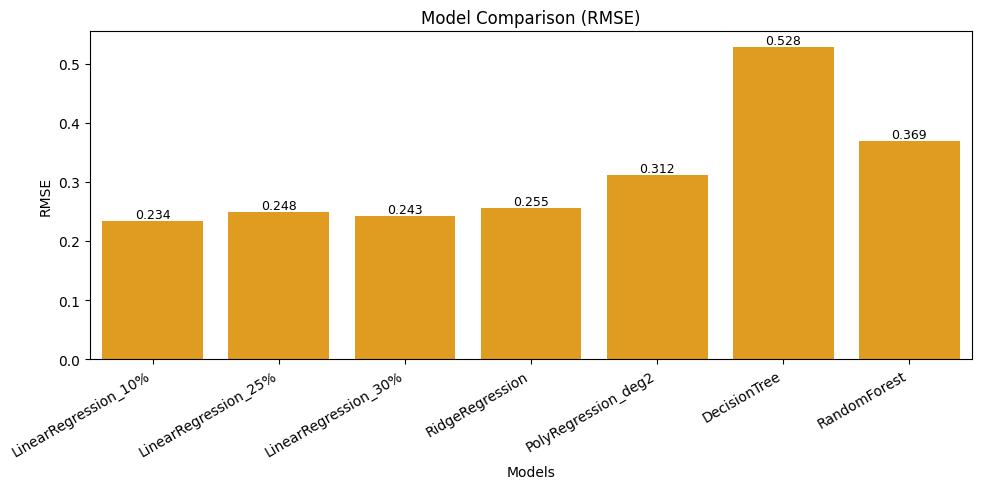

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
ax = sns.barplot(x="Model", y="RMSE", data=results_df, color="orange")

# Add labels above bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black')

plt.title("Model Comparison (RMSE)")
plt.ylabel("RMSE")
plt.xlabel("Models")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()



In [ ]:
# ---------------- Step 15: Final Test Evaluation ----------------
from sklearn.linear_model import LinearRegression
import joblib

# Pick the best model (lowest RMSE)
best_row = results_df.loc[results_df['RMSE'].idxmin()]
print("Best model is:", best_row['Model'], "with RMSE:", best_row['RMSE'])

# Since best is LinearRegression_10%, retrain it on that split
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(
    X, y, test_size=0.10, random_state=42
)

# Process with pipeline
X_train_best_proc = pipeline.fit_transform(X_train_best)
X_test_best_proc = pipeline.transform(X_test_best)

# Train the best model
best_model = LinearRegression()
best_model.fit(X_train_best_proc, y_train_best)

# Save the final model
joblib.dump(best_model, "best_model.pkl")
print("✅ Final model saved as best_model.pkl")

# Evaluate final model
y_pred_final = best_model.predict(X_test_best_proc)
final_mae = mean_absolute_error(y_test_best, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test_best, y_pred_final))
final_r2 = r2_score(y_test_best, y_pred_final)

print(f"Final Model on 10% Test → MAE={final_mae:.4f}, RMSE={final_rmse:.4f}, R²={final_r2:.4f}")



Best model is: LinearRegression_10% with RMSE: 0.234144160691876
✅ Final model saved as best_model.pkl
Final Model on 10% Test → MAE=0.1673, RMSE=0.2341, R²=0.9561


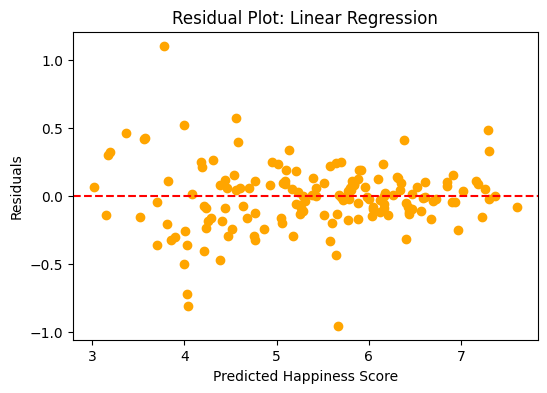

In [ ]:
y_pred = lr.predict(X_test_processed)
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, color='orange')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Happiness Score")
plt.ylabel("Residuals")
plt.title("Residual Plot: Linear Regression")
plt.show()